### SOME TRICKS 

that i've learned while trying to do particle spray using Galpy...

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
sys.path.append("/home/sferrone/stream-orbit-tracing/code/")
import trace_orbit as TO 
import json
import sys 
sys.path.append("/home/sferrone/GC-tidal-loss/simulations/analytic-GC-tidal-loss/code")
import inputMW
import orbitCoords as OC
import astropy.coordinates as coord
import astropy.units as u


### (1) Load in an a GC orbit and reproduce it 

In [4]:
k=0
GCnames,version,model=np.loadtxt("../code/clean_stream.txt",delimiter=',',dtype=str,unpack=True)
f=open("../code/config.json")
C = json.load(f)
dt=0.3
backwardpath,forwardpath=TO.orbitpath(C)
streampath=TO.get_streampath(version=version[k],model=model[k])
stream=h5py.File(streampath+GCnames[k]+".h5")
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
plt.style.use('dark_background')
dt=0.05
COM=OC.getCOM(GCnames[k])
past,future,x,y,z,vx,vy,vz=TO.absTimeFilter(dt,t,W)

EDR3 PII


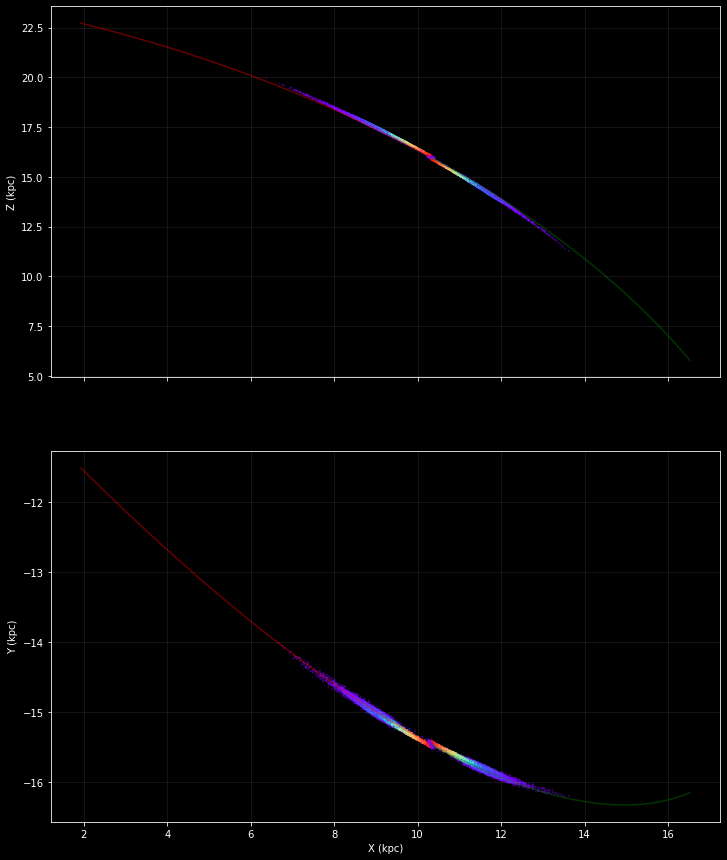

In [5]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(12,15))
coat=stream['energy']['Tescape'][:]
coat[coat<0]=0
ax[0].plot(x[past],z[past],alpha=0.4,c='r')
ax[0].plot(x[future],z[future],alpha=0.4,c='g')
ax[0].scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Z'][:],c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax[1].scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Y'][:],c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax[1].plot(x[past],y[past],alpha=0.4,c='r')
ax[1].plot(x[future],y[future],alpha=0.4,c='g')
ax[1].set_xlabel("X (kpc)")
ax[0].set_ylabel("Z (kpc)")
ax[1].set_ylabel("Y (kpc)")
for xx in ax:
    xx.grid("On",alpha=0.1)

## INITIALIZING AN ORBIT IN GALPY

Step one is to compute an orbit of a Globular cluster using Galpy. To do so, there are three components:
- the initial conditions
    - needs to be given in this order
        - [R, vR, vT, z, vZ, phi]
- the time at which we sample the orbit
    - Galpy figures out the integration and has a variety of schemas. The times we give as the times at which we sample this determiend orbit
- the galactic potential 
    - this is given a list of Potential instances from the Potential class.


### some problems I encountered:

The first is that my initial conditions are in galactic coordinates. I originally messed up my conversion! This is the correct way to convert to cylindrical: First do the position, then find the new unit vectors $
\^{e}_R, \^{e}_{\phi},$ and $\^{e}_z$


|R| = $\sqrt{x^2 + y^2}$

$\vec{R} = x \^{x} + y\^{y}$

$\^{e}_R = \vec{R} / |R|$

Then, we can find $\^{e}_{\phi}$ through the cross product:

$\^{e}_{\phi} = \^{e}_z \times \^{e}_R$

then, we can find the different velocity components through the dot product. 

$\vec{V_{T}} = \vec{V} \cdot \^{e}_{\phi}$

$\vec{V_{R}} = \vec{V} \cdot \^{e}_{R}$

$\vec{V_{z}} = \vec{V} \cdot \^{e}_{z}$

And lastly, in this problem the orbital phase, $\phi$, is important since we're trying to match data:

$\phi = \arctan\frac{y}{x}$

Remember the sign is important to know which quadrant we are in. Numpy as a np.argtan2(y,x) function, which takes care of this for us.

#### other things to note. 

Astropy is not compatibile with all numpy functions, for instance, `np.linalg.norm()`. So for this, we must drop the `Quantity` and only use the numerical value. Despite this, the units are necessary for `galpy.orbit.Orbit`


In [11]:
# MAKE THE VELOCITY AND CYLINDRICAL RADIUS VECTORS
vel=np.array([COM.v_x.value, COM.v_y.value, COM.v_z.value])

RR = np.array([COM.x.value, COM.y.value,0])
R=np.sqrt (COM.x**2 + COM.y**2)
magR = np.linalg.norm(RR)*u.kpc
RUnit = RR/np.linalg.norm(RR) # cannot use "Quantity" 
zUnit=[0,0,1]
tanUnit=np.cross(zUnit,RUnit)
# project velocity onto these axis and re-add units so that they are "Qauntity" objs
vT=np.dot(vel,tanUnit)*u.km/u.s
vR=np.dot(vel,RUnit)*u.km/u.s
vZ=np.dot(vel,[0,0,1])*u.km/u.s

phi = np.arctan2(COM.y,COM.x)
phi=phi.value*(180/np.pi)*u.degree

print("Verify that the speed is the same before and after conversion")
print(np.linalg.norm(vel),np.linalg.norm(np.array([vT.value,vR.value,vZ.value])))


Verify that the speed is the same before and after conversion
236.82399975543242 236.82399975543242


#### Initialize an instance of the Orbit object

In [14]:
from galpy.orbit import Orbit
orb=Orbit([R,vR,vT,COM.z,vZ,phi])

We need a potential model as well as the times at which we write out the orbit's position. In regards to the time, Galpy uses these "natural units". In this system:
- $R_{nat}$ is the unit of distance, which is 1 at the galactocentric distance where the *circular velocity* is maximum
- $v_{nat}$ is the velocity, which is 1 at the maximum circular velocity of the potential model. 
- $t_{nat}$ is a fraction of $2\pi$, where $2 \pi t_{nat}$ is the amount of time required to complete one circular orbit at $R_{nat}$=1

In regards to the Potential, there are a series of different classes in the `galpy.potential` library. We are going to use the model pulished by Bovy et al 2014. Notice that this `MWPotential2014` is not an instance of the potential class, but is instead a python `list` of different potential instances. This unfortunately we do not have access to the methods available for instances of the `Potential` class. But this is okay, integrate can take either a list of potentials or a potential. If you wish to get the rotation curve of a Potential instance you must use some of other utilities in Galpy. 

In regards to time, the best practice is to get tmax to be a couple multiples of $2 \pi$. How many orbits around the galactic pole will depend on the initial conditions, but this gives the rough idea...

- question -> I wonder if Galpy has a conversion to return *natural time* to billions of years?


In [49]:
from galpy.potential import MWPotential2014 as MW14
t0,tf,N=0,6*(2*np.pi),100
ts=np.linspace(t0,tf,N)
orb.integrate(ts,MW14)

Notice that nothing is returned from `orb.integrate(ts,MW14)`. All of the information is saved within the orbit instance. 

In [50]:
from galpy.util import conversion
conv=conversion.get_physical(orb)

We also need to use the conversion object because `Orbit.getOrbit()` returns [R,vR,vT,z,vZ,$\phi$] is natural units, while `Orbit.phi()` and `orb.R()` come in the given units 

Text(0, 0.5, 'y (natural)')

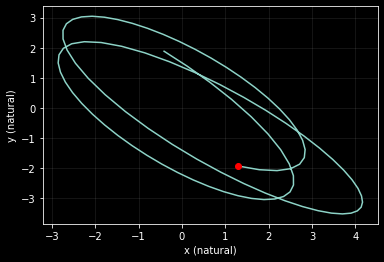

In [68]:
CX=orb.R()*np.cos(orb.phi())
CY=orb.R()*np.sin(orb.phi())
myx=orb.getOrbit()[:,0]*np.cos(orb.getOrbit()[:,5])
myy=orb.getOrbit()[:,0]*np.sin(orb.getOrbit()[:,5])
plt.plot(myx,myy)
plt.plot(CX/conv['ro'],CY/conv['ro'], 'ro')
plt.grid("on",alpha=0.1)
plt.xlabel("x (natural)")
plt.ylabel("y (natural)")

### No Naive backward orbit from negative $t_0$!

I cannot not ask it to integrate at negative times. It does not integrate backwards. It appears as though Galpy will zero the time to the first value and then integrate forward. 

(Text(0.5, 0, 'x (natural)'), Text(0, 0.5, 'y (natural)'), None)

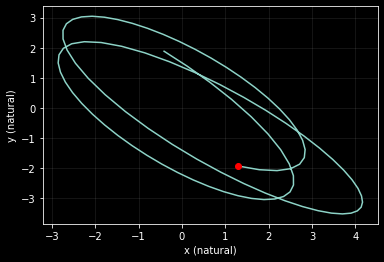

In [69]:
t0,tf,N=0,6*(2*np.pi),100
ts=np.linspace(-tf,tf,N) # TRYING TO INTEGRATE BACKWARD! 
orb.integrate(ts,MW14)
CX,CY=orb.R()*np.cos(orb.phi()),orb.R()*np.sin(orb.phi())
myx,myy=orb.getOrbit()[:,0]*np.cos(orb.getOrbit()[:,5]),orb.getOrbit()[:,0]*np.sin(orb.getOrbit()[:,5])
plt.plot(myx,myy),plt.plot(CX/conv['ro'],CY/conv['ro'], 'ro')
plt.xlabel("x (natural)"),plt.ylabel("y (natural)"),plt.grid("on",alpha=0.1)

### You must compute the backward orbit as a seperate object
You must make the initial velocity negative

In [70]:
orbB,orbF=Orbit([R,-vR,-vT,COM.z,-vZ,phi]),Orbit([R,vR,vT,COM.z,vZ,phi])
t0,tf,N=0,6*(2*np.pi),100
ts=np.linspace(t0,tf,N)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14)

(None, None)

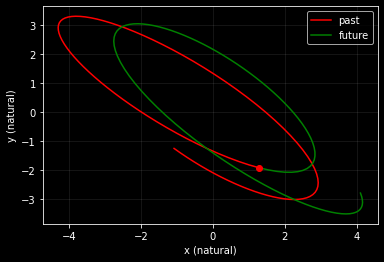

In [71]:
CX,CY=orbB.R()*np.cos(orbB.phi()),orbB.R()*np.sin(orbB.phi())
myxB,myyB=orbB.getOrbit()[:,0]*np.cos(orbB.getOrbit()[:,5]),orbB.getOrbit()[:,0]*np.sin(orbB.getOrbit()[:,5])
myxF,myyF=orbF.getOrbit()[:,0]*np.cos(orbF.getOrbit()[:,5]),orbF.getOrbit()[:,0]*np.sin(orbF.getOrbit()[:,5])
plt.plot(myxB,myyB,'r',label="past"),plt.plot(myxF,myyF,'g',label="future"),plt.plot(CX/conv['ro'],CY/conv['ro'], 'ro')
plt.xlabel("x (natural)"),plt.ylabel("y (natural)"),plt.grid("on",alpha=0.1)
plt.legend()

### Now I wish to over plot this with my orbit and the stream

Decrease the time alot!

In [92]:
orbB,orbF=Orbit([R,-vR,-vT,COM.z,-vZ,phi]),Orbit([R,vR,vT,COM.z,vZ,phi])
t0,tf,N=0,0.25*(2*np.pi),100
ts=np.linspace(t0,tf,N)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14);

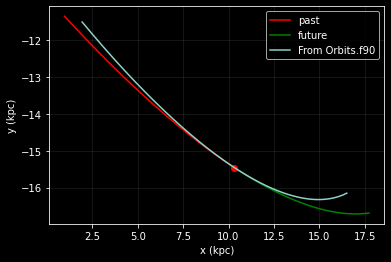

In [93]:
CX,CY=orbB.R()*np.cos(orbB.phi()),orbB.R()*np.sin(orbB.phi())
myxB,myyB=orbB.getOrbit()[:,0]*np.cos(orbB.getOrbit()[:,5]),orbB.getOrbit()[:,0]*np.sin(orbB.getOrbit()[:,5])
myxF,myyF=orbF.getOrbit()[:,0]*np.cos(orbF.getOrbit()[:,5]),orbF.getOrbit()[:,0]*np.sin(orbF.getOrbit()[:,5])
myxB,myyB=conv['ro']*myxB,conv['ro']*myyB
myxF,myyF=conv['ro']*myxF,conv['ro']*myyF
plt.plot(myxB,myyB,'r',label="past"),plt.plot(myxF,myyF,'g',label="future"),plt.plot(CX,CY, 'ro')
plt.xlabel("x (kpc)"),plt.ylabel("y (kpc)"),plt.grid("on",alpha=0.1)
plt.plot(x,y,label="From Orbits.f90")
plt.legend();

### Remarks

It looks like the galactic potential model makes a responable difference.

**But** does it matter where the stream is plotted? Let us over plot the stream and zoom in

In [94]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
ax.plot(myxB,myyB,'r',label="Galpy Past"),ax.plot(myxF,myyF,'g',label="Galpy Future"),ax.plot(CX,CY, 'ro')
ax.scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Y'][:],\
            c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.plot(x,y,label="From Orbits.f90")
ax.set_xlabel("x (kpc)"),ax.set_ylabel("y (kpc)"),ax.grid("on",alpha=0.1)
ax.legend()
ax.set_ylim(stream['galactocentric']['Y'][:].min(),stream['galactocentric']['Y'][:].max())
ax.set_xlim(stream['galactocentric']['X'][:].min(),stream['galactocentric']['X'][:].max())
ax.set_aspect("equal")
ax.set_title(GCnames[k]);

### HERE IS AN IMPORTANT RESULT! 

- divergence between orbits seems significant with escape times >4Gyrs
- It does seem as though there is this "wedgeing" behavior, the escape time is more confused within along the axis of the stream, but at larger radial distances the seperation seems more seperable 

### A thought

Can I use the length of the streams to estiamte how far back in the past I need to go with particle spray to cover the whole length?

some kind of ratio ? maybe a $(\delta v / v) t_c$ 